In [1]:
import nltk 
import re 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import re, codecs
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import time

import seaborn as sns


# Simple Stemming

In [2]:
#проверка
def comparison(word1, word2):
    length = len(word2) if len(word1) > len(word2) else len(word1)
    result = ''
    for i in range(length):
        if(word1[i] == word2[i]):
            result = result + word1[i]
        else:
            break
    return result
#простой стемминг
def stemming_kazakh(docin, doc):
    alldocin = docin.split(' ')
    docin = doc.split(' ')
    result = []
    for i in range(len(alldocin)):
        for j in range(len(docin)):
            s = comparison(alldocin[i], docin[j])
            if(len(s) > 3):
                docin[j] = s
    
    return " ".join(str(x) for x in docin)
#стемминг для всего документов
def clean_all_datas(data_list):
    merged = ' '.join(data_list[:100])
    cleaned = []
    iter = 1
    length = len(data_list)
    for i in data_list:
        cleaned.append(stemming_kazakh(merged, i))
        print(iter,'/',length)
        iter += 1
    return cleaned
#очистка от ненужный(шумных) символов
def cleaning_data(code_data):
    text = code_data.text.tolist()
    label = code_data.label.tolist()
    sentences = []
    for line in range(len(text)):
        pre = re.sub(r'http\S+', '', str(text[line])).replace(r'<a href="', '')
        stripped = re.sub('[^a-zA-Z, ^А-Я,а-я,Ә,І,Ң,Ғ,Ү,Ұ,Қ,Ө,Һ,ә,і,ə,ң,ғ,ү,ұ,қ,ө,һ]', ' ', pre.replace('-', ''))
        stripped = re.sub('_', '', stripped)
        stripped = re.sub('\s+', ' ', stripped)
        sentences.append([str(stripped).lower(), int(label[line])])
    return pd.DataFrame(sentences, columns = ['text', 'label'])

# Reading raw text and Writing clean text

# Reading clean text

In [3]:
def more_three(df):
    text = df.text.tolist()
    label = df.label.tolist()
    new_df = []
    for i in range(len(text)):
        if(len(text[i].split(' ')) > 3):
            new_df.append([text[i], label[i]])
        
    return pd.DataFrame(new_df, columns = ["text", "label"])

In [4]:
#df = pd.read_csv('Corpus/corpus_cleaned.csv')
df = pd.read_csv('Corpus/corpus_stemmed.csv')
df = cleaning_data(df)
df['text'] = df['text'].astype(str)
df['label'] = pd.to_numeric(df['label'])
df

,text,label
0,лива туввар сири алла islamstate қарс ұрыс баст,1
1,терр итте бүлі айна turkey pkk twitterkurds t,1
2,әлха газва арна айма олар кейі олар алепп қайт...,1
3,сири ресе n басы кіру тура алаң кіру мүмкін ем...,1
4,ядролық соғы соғы келе жаты,1
...,...,...
13163,"қарт шаққа дейі өмір сүре кепіл бере бе жоқ, е...",0
13164,ан оқып үйре сіз үшін бүгі кере ұсын бар курс ...,0
13165,таз жеке текс қада толы ақпа алу үшін сілте өт...,0
13166,а таға кеші тіле шүкір ете отыр рабб пәкт ұлық...,0


In [5]:
df = more_three(df)
df.to_csv("Corpus/corpus_stemmed_more3.csv", index = False)
df

,text,label
0,лива туввар сири алла islamstate қарс ұрыс баст,1
1,терр итте бүлі айна turkey pkk twitterkurds t,1
2,әлха газва арна айма олар кейі олар алепп қайт...,1
3,сири ресе n басы кіру тура алаң кіру мүмкін ем...,1
4,ядролық соғы соғы келе жаты,1
...,...,...
11676,"қарт шаққа дейі өмір сүре кепіл бере бе жоқ, е...",0
11677,ан оқып үйре сіз үшін бүгі кере ұсын бар курс ...,0
11678,таз жеке текс қада толы ақпа алу үшін сілте өт...,0
11679,а таға кеші тіле шүкір ете отыр рабб пәкт ұлық...,0


# Visualization

In [6]:
n_tops = 20

In [10]:
def get_gram(data_list, n):
    vectorizer = CountVectorizer(ngram_range =(n, n), stop_words=nltk.corpus.stopwords.words('kazakh'))
    #vectorizer = TfidfVectorizer(ngram_range = (n,n))
    X = vectorizer.fit_transform(data_list)
    features = (vectorizer.get_feature_names())
    sums = X.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append( (term, sums[0,col] ))
    ranking = pd.DataFrame(data1, columns = ['term','value'])
    words = (ranking.sort_values('value', ascending = False))
    return  words

def plotting_ngram(gram_df, n):
    gram = pd.DataFrame(gram_df[:n])
    d = gram.set_index('term').T.to_dict('rank')[:1]

    G = nx.Graph()
    
    for k, v in d[0].items():
        G.add_edge(k.split()[0], k.split()[1], weight=(v * 10))

    fig, ax = plt.subplots(figsize=(12, 8))

    pos = nx.spring_layout(G, k=2)

    nx.draw_networkx(G, pos,
                     font_size=16,
                     width=3,
                     edge_color='blue',
                     node_color='red',
                     with_labels = False,
                     ax=ax)

    for key, value in pos.items():
        x, y = value[0]+.135, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='purple', alpha=0.25),
                horizontalalignment='center', fontsize=10)
    
    plt.show()

In [11]:
unigram_df = get_gram(df.text.tolist(), 1)
print ("\n\nUnigram : \n", unigram_df.head(n_tops))

c:\users\zhastay\appdata\local\programs\python\python36\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген'] not in stop_words.
  'stop_words.' % sorted(inconsistent))




Unigram : 
         term  value
1467    алла   4532
4326    және   4481
1265    адам   2356
2599     бір   2240
3027      да   2166
7956    сонд   1952
3116      де   1918
3162     деп   1867
2439    бола   1680
3930    жаса   1485
7804    сенд   1473
10661   қала   1434
10709   қарс   1223
2227    басқ   1211
2444    болс   1182
4728   ислам   1111
2450    болғ   1079
3970    жақс   1071
10464   істе   1071
8816    тура   1028


[Text(0, 0, 'алла'),
 Text(0, 0, 'және'),
 Text(0, 0, 'адам'),
 Text(0, 0, 'бір'),
 Text(0, 0, 'да'),
 Text(0, 0, 'сонд'),
 Text(0, 0, 'де'),
 Text(0, 0, 'деп'),
 Text(0, 0, 'бола'),
 Text(0, 0, 'жаса'),
 Text(0, 0, 'сенд'),
 Text(0, 0, 'қала'),
 Text(0, 0, 'қарс'),
 Text(0, 0, 'басқ'),
 Text(0, 0, 'болс'),
 Text(0, 0, 'ислам'),
 Text(0, 0, 'болғ'),
 Text(0, 0, 'жақс'),
 Text(0, 0, 'істе'),
 Text(0, 0, 'тура')]

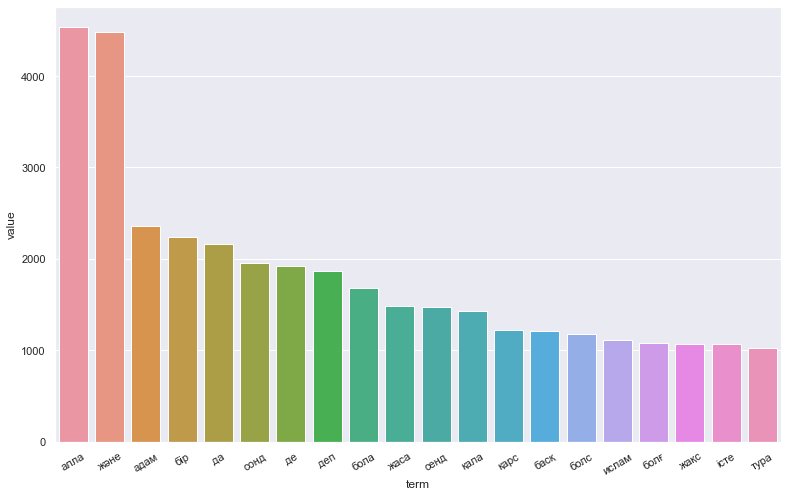

In [15]:
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="term", y="value", data=unigram_df[:20])
g.set_xticklabels(g.get_xticklabels(), rotation=30)

c:\users\zhastay\appdata\local\programs\python\python36\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген'] not in stop_words.
  'stop_words.' % sorted(inconsistent))




Bigram : 
                term  value
8067      алла таға    368
66456     иман келт    360
130882  шабуыл жаса    237
109793    сонд алла    207
46276     ерек мейі    181
2457      адам бала    169
7728      алла елші    152
39801      деп ойла    150
158180      әр нәрс    150
27663     болы табы    142
133379     шын мәні    135
109166   содан кейі    133
20415      бас тарт    128
26913       болс да    127
7613      алла атым    124
145359    қиям күні    119
62480     жұмы істе    119
91588       не істе    118
110665    соны қата    117
8018      алла сенд    115


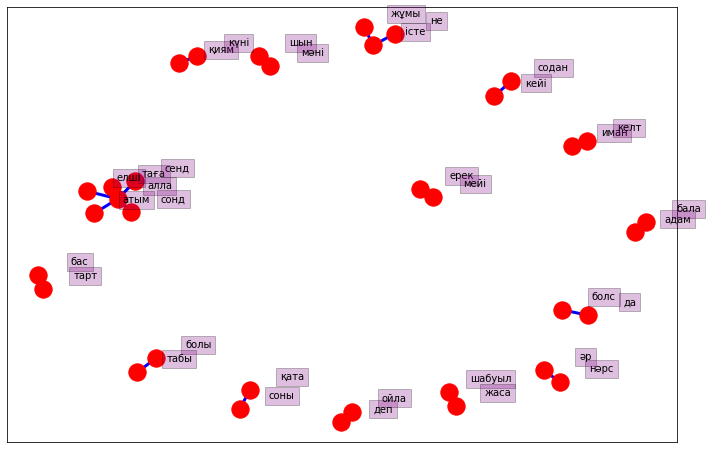

In [12]:
bigram_df = get_gram(df.text.tolist(), 2)
print ("\n\nBigram : \n", bigram_df.head(n_tops))
plotting_ngram(bigram_df, n_tops)

[Text(0, 0, 'алла таға'),
 Text(0, 0, 'иман келт'),
 Text(0, 0, 'шабуыл жаса'),
 Text(0, 0, 'сонд алла'),
 Text(0, 0, 'ерек мейі'),
 Text(0, 0, 'адам бала'),
 Text(0, 0, 'алла елші'),
 Text(0, 0, 'деп ойла'),
 Text(0, 0, 'әр нәрс'),
 Text(0, 0, 'болы табы'),
 Text(0, 0, 'шын мәні'),
 Text(0, 0, 'содан кейі'),
 Text(0, 0, 'бас тарт'),
 Text(0, 0, 'болс да'),
 Text(0, 0, 'алла атым'),
 Text(0, 0, 'қиям күні'),
 Text(0, 0, 'жұмы істе'),
 Text(0, 0, 'не істе'),
 Text(0, 0, 'соны қата'),
 Text(0, 0, 'алла сенд')]

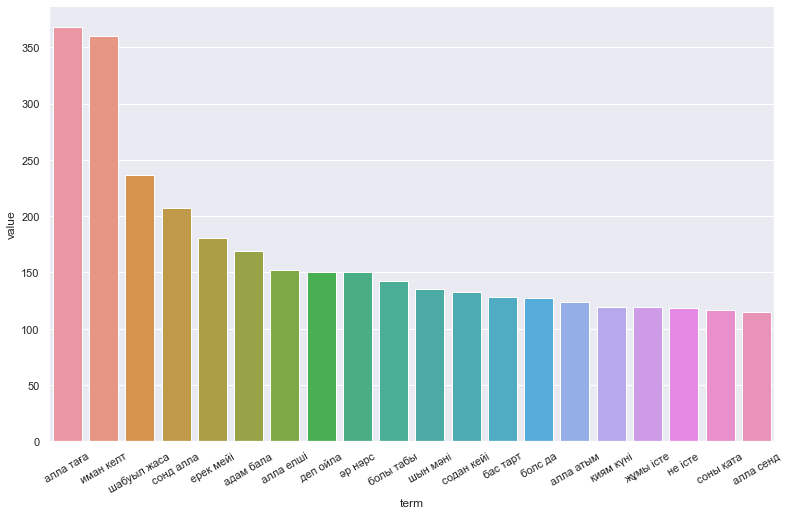

In [16]:
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="term", y="value", data=bigram_df[:20])
g.set_xticklabels(g.get_xticklabels(), rotation=30)

c:\users\zhastay\appdata\local\programs\python\python36\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген'] not in stop_words.
  'stop_words.' % sorted(inconsistent))




Trigram : 
                     term  value
10469     алла атым баст     97
70376     ерек мейі алла     95
125596    мейі алла атым     94
204878    қамқ ерек мейі     94
13033       алла әр нәрс     60
16270     амер құра штат     55
78217     жары ерек мейі     53
22556   ауған ислам әмір     52
224313      әбу әли әлха     49
128505      муфт әбу әли     49
197172      ізгі іс істе     48
51383     бұқа ақпа құра     46
11808     алла разы болс     42
177383   тура жолға сала     38
107752      келт ізгі іс     38
204102   қалды келе болу     35
71874    есім қалды келе     35
70069   ентке есім қалды     35
100729    иман келт ізгі     35
106484  келе болу мүмкін     35


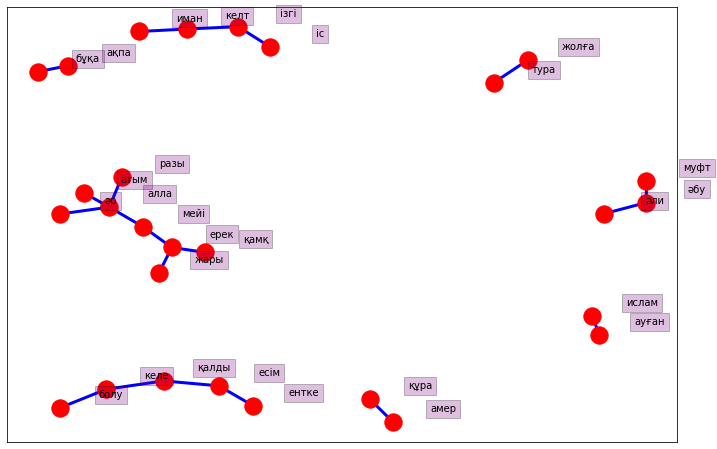

In [13]:
trigram_df = get_gram(df.text.tolist(), 3)
print ("\n\nTrigram : \n", trigram_df.head(n_tops))
plotting_ngram(trigram_df, n_tops)

[Text(0, 0, 'алла атым баст'),
 Text(0, 0, 'ерек мейі алла'),
 Text(0, 0, 'мейі алла атым'),
 Text(0, 0, 'қамқ ерек мейі'),
 Text(0, 0, 'алла әр нәрс'),
 Text(0, 0, 'амер құра штат'),
 Text(0, 0, 'жары ерек мейі'),
 Text(0, 0, 'ауған ислам әмір'),
 Text(0, 0, 'әбу әли әлха'),
 Text(0, 0, 'муфт әбу әли'),
 Text(0, 0, 'ізгі іс істе'),
 Text(0, 0, 'бұқа ақпа құра'),
 Text(0, 0, 'алла разы болс'),
 Text(0, 0, 'тура жолға сала'),
 Text(0, 0, 'келт ізгі іс'),
 Text(0, 0, 'қалды келе болу'),
 Text(0, 0, 'есім қалды келе'),
 Text(0, 0, 'ентке есім қалды'),
 Text(0, 0, 'иман келт ізгі'),
 Text(0, 0, 'келе болу мүмкін')]

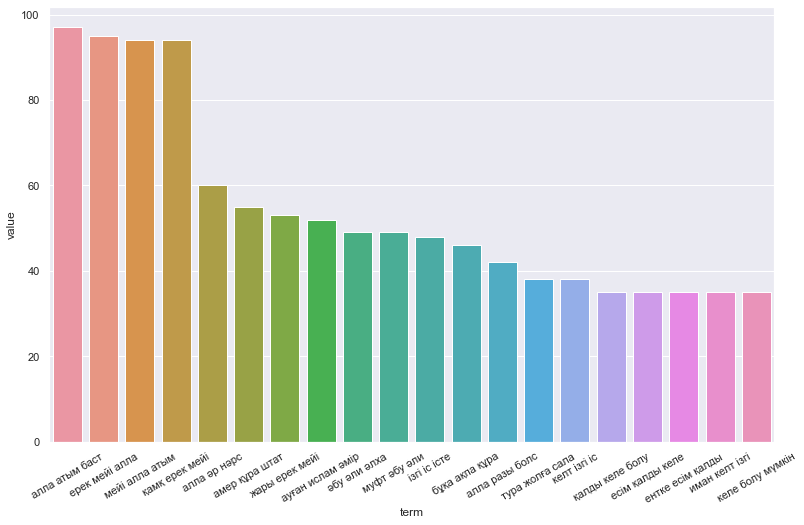

In [17]:
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="term", y="value", data=trigram_df[:20])
g.set_xticklabels(g.get_xticklabels(), rotation=30)

c:\users\zhastay\appdata\local\programs\python\python36\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген'] not in stop_words.
  'stop_words.' % sorted(inconsistent))




Quadrigram : 
                           term  value
207559     қамқ ерек мейі алла     92
71793      ерек мейі алла атым     91
127532     мейі алла атым баст     91
130456       муфт әбу әли әлха     48
109710       келт ізгі іс істе     37
73264     есім қалды келе болу     35
206791  қалды келе болу мүмкін     35
71476    ентке есім қалды келе     35
102522       иман келт ізгі іс     35
188353    уә рахм уә бәракәтуһ     30
152333   рабб қай нығмет өтірі     30
204555   қай нығмет өтірі дейс     30
75106      еше рабб қай нығмет     29
20285       аса жары ерек мейі     28
11456     алла игіл сәлем болс     25
10347       алла аса жары ерек     21
11806        алла не істе толы     21
226896          әбу ли əл хана     20
124378         ли əл хана хафи     20
130453          муфт әбу ли əл     20


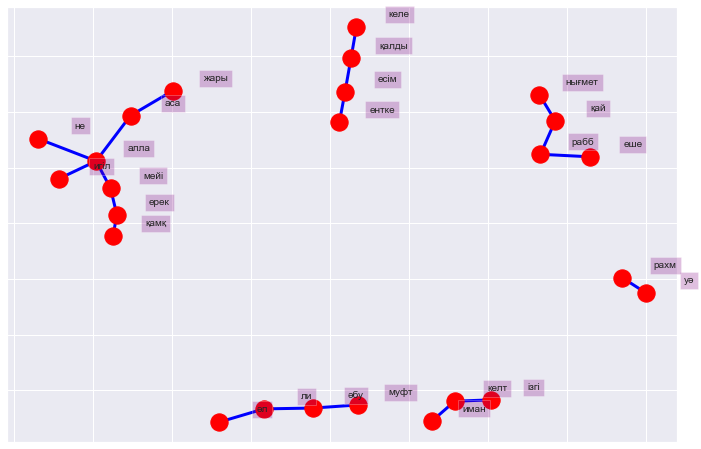

In [18]:
quadrigram_df = get_gram(df.text.tolist(), 4)
print ("\n\nQuadrigram : \n", quadrigram_df.head(n_tops))
plotting_ngram(quadrigram_df, n_tops)

[Text(0, 0, 'қамқ ерек мейі алла'),
 Text(0, 0, 'ерек мейі алла атым'),
 Text(0, 0, 'мейі алла атым баст'),
 Text(0, 0, 'муфт әбу әли әлха'),
 Text(0, 0, 'келт ізгі іс істе'),
 Text(0, 0, 'есім қалды келе болу'),
 Text(0, 0, 'қалды келе болу мүмкін'),
 Text(0, 0, 'ентке есім қалды келе'),
 Text(0, 0, 'иман келт ізгі іс'),
 Text(0, 0, 'уә рахм уә бәракәтуһ'),
 Text(0, 0, 'рабб қай нығмет өтірі'),
 Text(0, 0, 'қай нығмет өтірі дейс'),
 Text(0, 0, 'еше рабб қай нығмет'),
 Text(0, 0, 'аса жары ерек мейі'),
 Text(0, 0, 'алла игіл сәлем болс'),
 Text(0, 0, 'алла аса жары ерек'),
 Text(0, 0, 'алла не істе толы'),
 Text(0, 0, 'әбу ли əл хана'),
 Text(0, 0, 'ли əл хана хафи'),
 Text(0, 0, 'муфт әбу ли əл')]

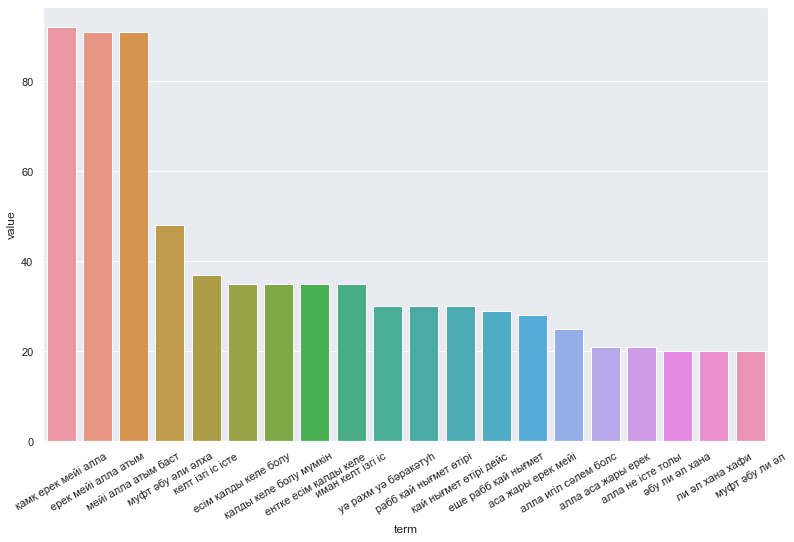

In [19]:
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="term", y="value", data=quadrigram_df[:20])
g.set_xticklabels(g.get_xticklabels(), rotation=30)